## 実データNFPO
今回はタグ間相互結合を無視するためにタグアレイで実験

In [1]:
import sys
sys.path.append("../../analysis")

import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from typing import Optional
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from classes import NFPO
from classes import NFPO_PDOA
%matplotlib inline

warnings.simplefilter('ignore')

In [2]:
tag_location = {
    "x": 1,
    "y": 1.5,
}
tag_population = 5
tags_number = range(tag_population)
tags_space = 0.1
frequency = 918.0e6
light_speed = 2.998e8
wave_length = light_speed / frequency
angular_velocity = 2 * np.pi * frequency
sample_count = 100

## データ整形

In [3]:
data_set = {}
columns = ["rssi","phase","samplingNumber"]
for x in range(-100, 100, 50):
    df = pd.read_csv(f"../data/nfpo/{x}.csv")
    df2 = df[df["tagNumber"]==0][columns].rename(
            columns={
                "rssi": f"tag{0}_rssi",
                "phase": f"tag{0}_phase"
            }
        )
    for i in range(1, tag_population):
        merged_df = df[df["tagNumber"]==i][columns].rename(
            columns={
                "rssi": f"tag{i}_rssi",
                "phase": f"tag{i}_phase"
            }
        )
        df2 = pd.merge(df2, merged_df, on="samplingNumber")
    data_set[f"{x/100}m"]={
        "actual_coordinate":{"x":x/100, "y":1.088},
        "df": df2,
        "phase_np": df2[[f"tag{t}_phase" for t in range(tag_population)]].to_numpy(),
        "rssi_np": df2[[f"tag{t}_rssi" for t in range(tag_population)]].to_numpy()
    }

## 最適化

In [4]:
for x in range(-100, 100, 50):
    x_m = x/100
    data_set[f"{x_m}m"]["nfpo"]=NFPO(
        sample_count=sample_count, 
        tags_space=tags_space, 
        phases=data_set[f"{x_m}m"]["phase_np"], 
        tag_population=tag_population, 
        wave_length=wave_length, 
        tag_location=data_set[f"{x_m}m"]["actual_coordinate"], 
        initial_value={"x":0,"y":1}, 
        x_err_range=0.3,
        y_err_range=0.3,
    )
    result = data_set[f"{x_m}m"]["nfpo"].solve(tee=True)
    actual_coordinate = data_set[f"{x_m}m"]["actual_coordinate"]
    R = [sqrt((actual_coordinate["x"]+m*0.1)**2+actual_coordinate["y"]**2) for m in range(tag_population)]
    N = [(-r * 4*np.pi / wave_length) // (2*np.pi) for r in R]
    actual_coordinate["N"] = N
    err = sqrt((actual_coordinate["x"]-result["values"]["x"])**2 + (actual_coordinate["y"]-result["values"]["y"])**2)
    print(f"Actual Values = {actual_coordinate}\n    Solve time = {result["solving_time"]}[s]\n    Values = {result["values"]}\n    Error = {err}[m]")
    data_set[f"{x_m}m"]["nfpo"].del_component()

AttributeError: 'NFPO' object has no attribute '_NFPO__error_initialize'

In [ ]:
err_index = []
for x in range(-100, 100, 50):
    x_m = x/100
    nfpo = data_set[f"{x_m}m"]["nfpo"]
    err_list = []
    print(f"Actual coordinate = {data_set[f"{x_m}m"]["actual_coordinate"]}")
    for err_cm in range(0,101):
        err_m = err_cm/100
        nfpo.renew_parameter(x_err_range=err_m, y_err_range=err_m)
        result = nfpo.solve()
        actual_coordinate = data_set[f"{x_m}m"]["actual_coordinate"]
        err = sqrt((actual_coordinate["x"]-result["values"]["x"])**2 + (actual_coordinate["y"]-result["values"]["y"])**2)
        err_list.append(err)
        nfpo.del_component()
        print(f"    Error Range = {err_m}[m]\n      Solve time = {result["solving_time"]}[s]\n      Error = {err}[m]")
    err_index.append(err_list)

Actual coordinate = {'x': -1.0, 'y': 1.088, 'N': [-10.0, -9.0, -9.0, -8.0, -8.0]}
    Error Range = 0.0[m]
      Solve time = 0.09[s]
      Error = 0.0[m]
    Error Range = 0.01[m]
      Solve time = 0.19[s]
      Error = 0.014142149728804782[m]
    Error Range = 0.02[m]
      Solve time = 0.18[s]
      Error = 0.028284273339553925[m]
    Error Range = 0.03[m]
      Solve time = 0.18[s]
      Error = 0.035565827014084006[m]
    Error Range = 0.04[m]
      Solve time = 0.57[s]
      Error = 0.038211644914664014[m]
    Error Range = 0.05[m]
      Solve time = 0.56[s]
      Error = 0.038532858779829385[m]
    Error Range = 0.06[m]
      Solve time = 0.58[s]
      Error = 0.03851779400606613[m]
    Error Range = 0.07[m]
      Solve time = 0.57[s]
      Error = 0.038234855164810885[m]
    Error Range = 0.08[m]
      Solve time = 0.59[s]
      Error = 0.038369038444817184[m]
    Error Range = 0.09[m]
      Solve time = 0.67[s]
      Error = 0.038553313148297026[m]
    Error Range = 0.1[m]
  

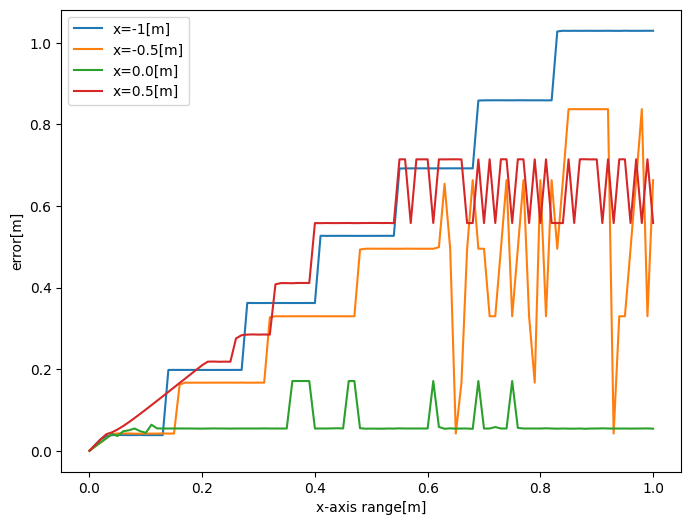

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
i=-1
for err_list in err_index:
    ax.plot([x_cm/100 for x_cm in range(0,101)], err_list, label=f"x={i}[m]")
    i=i+0.5
ax.set_xticks([x_cm/100 for x_cm in range(0,101,20)])
ax.set_xlabel("x-axis range[m]")
ax.set_ylabel("error[m]")
ax.legend()
fig.show()

In [ ]:
err_matrix = []
solve_time_matrix = []
for x_cm in range(-100, 100, 50):
    x_err_range=2.0
    y_err_range=1.0
    initial_value = {"x":0.0, "y":1.0}
    x_m = x_cm/100
    correct_value = data_set[f"{x_m}m"]["actual_coordinate"]
    err_list = [sqrt((correct_value["x"]-initial_value["x"])**2 + (correct_value["y"]-initial_value["y"])**2)]
    solve_time_list = []
    nfpo = data_set[f"{x_m}m"]["nfpo"]
    for i in range(1,101):
        nfpo.renew_parameter(x_err_range=x_err_range, y_err_range=y_err_range, initial_value=initial_value, tag_location=initial_value)
        result=nfpo.solve()
        result_value = result["values"]
        initial_value = result_value
        solve_time = result["solving_time"]
        solve_time_list.append(solve_time)
        err = sqrt((correct_value["x"]-result_value["x"])**2 + (correct_value["y"]-result_value["y"])**2)
        err_list.append(err)
        x_err_range = x_err_range - 0.02
        y_err_range = y_err_range - 0.01
        nfpo.del_component()
    err_matrix.append(err_list)
    solve_time_matrix.append(solve_time_list)

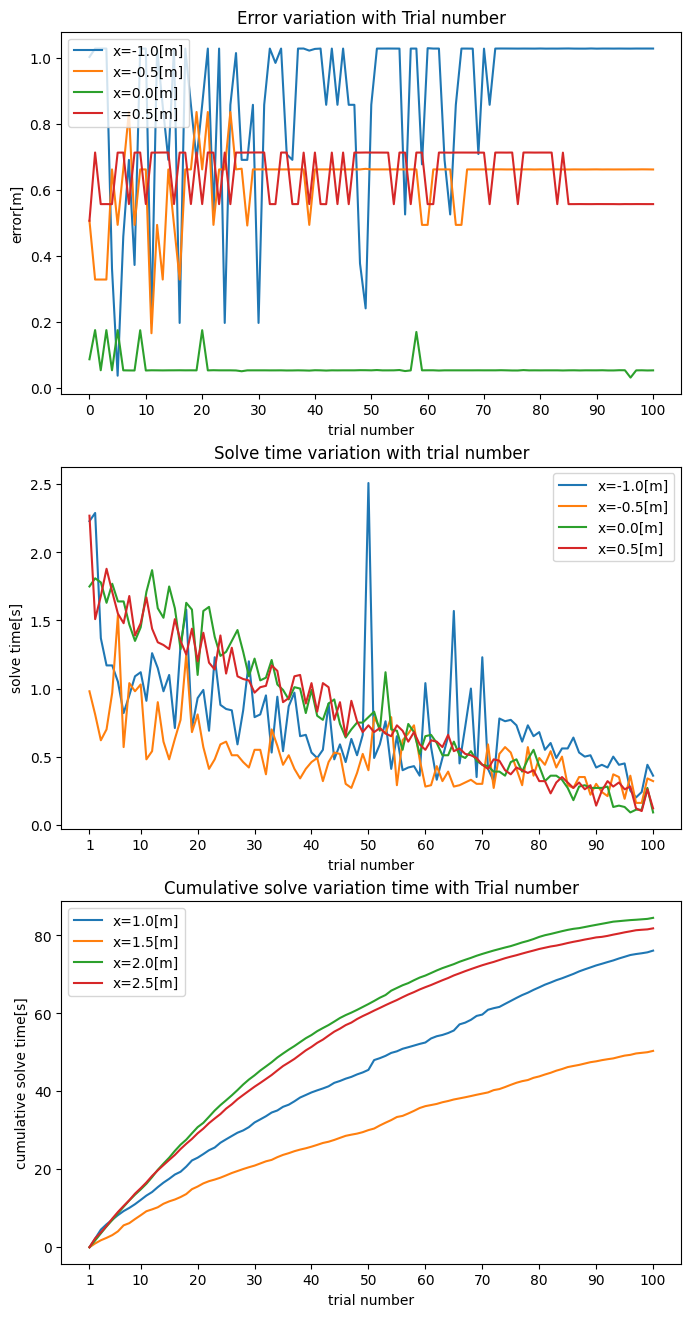

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(8,16))
i=-1.0
for err_list in err_matrix:
    axes[0].plot(list(range(0,101)), err_list, label=f"x={i}[m]")
    i=i+0.5
i=-1.0
for solve_time_list in solve_time_matrix:
    axes[1].plot(list(range(1,101)), solve_time_list, label=f"x={i}[m]")
    i=i+0.5
for solve_time_list in solve_time_matrix:
    axes[2].plot(list(range(1,101)), [sum(solve_time_list[:j]) for j in range(len(solve_time_list))], label=f"x={i}[m]")
    i=i+0.5
axes[0].set_xticks(range(0,101,10))
axes[0].set_xlabel("trial number")
axes[0].set_ylabel("error[m]")
axes[0].set_title("Error variation with Trial number")
axes[0].legend()
axes[1].set_xticks([1] + list(range(10,101,10)))
axes[1].set_xlabel("trial number")
axes[1].set_ylabel("solve time[s]")
axes[1].set_title("Solve time variation with trial number")
axes[1].legend()
axes[2].set_xticks([1] + list(range(10,101,10)))
axes[2].set_xlabel("trial number")
axes[2].set_ylabel("cumulative solve time[s]")
axes[2].set_title("Cumulative solve variation time with Trial number")
axes[2].legend()
fig.show()

## 位相精度検証

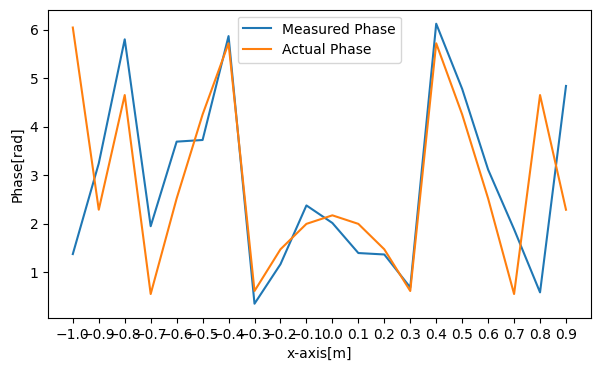

In [ ]:
i=0
actual_phase = []
phase = []
fig, ax = plt.subplots(figsize = (7,4))
for x in range(-100, 100, 50):
    x_m = x/100
    actual_phase = actual_phase + [np.mod(-4*np.pi*sqrt((x_m+m*tags_space)**2 + 1.088**2)/wave_length, 2*np.pi) for m in range(tag_population)]
    df = data_set[f"{x_m}m"]["df"]
    phase = phase + [df[f"tag{t}_phase"].mean() for t in range(tag_population)]
ax.plot([x_cm/100 for x_cm in range(-100, 100, 10)], phase, label="Measured Phase")
ax.plot([x_cm/100 for x_cm in range(-100, 100, 10)], actual_phase, label="Actual Phase")
ax.set_ylabel("Phase[rad]")
ax.set_xlabel("x-axis[m]")
ax.set_xticks([x_cm/100 for x_cm in range(-100, 100, 10)])
ax.legend()
fig.show()

In [ ]:
# def phase_nonlinear_fit(x,A):
#     return np.mod(-(4*np.pi*np.sqrt(x**2+1.3**2)/wave_length + A), 2*np.pi)

In [ ]:
# param, cov = curve_fit(phase_nonlinear_fit, [x_cm/100 for x_cm in range(-100, 100, 10)], phase)
# result_list = []
# for x_m in [x_cm/100 for x_cm in range(-100, 100, 10)]:
#     result_list.append(np.mod(-(4*np.pi*np.sqrt(x_m**2+1.3**2)/wave_length + param[0]), 2*np.pi))

# print(param)

# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot([x_cm/100 for x_cm in range(-100, 100, 10)], result_list)
# ax.plot([x_cm/100 for x_cm in range(-100, 100, 10)], phase)
# fig.show()

In [ ]:
4*np.pi*0.5*(3.6*10**6)/light_speed

0.07544852270128923